# Feature performance comparison

The purpose of this notebook is to compare the classification performance of the individual features, and their combination, for A. Thaliana

# Imports

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../../src")
from main.transporter_dataset import create_dataset
from main.eval import (
    get_independent_test_set,
    optimize_hyperparams,
    preprocess_pandas,
    models_quick_compare,
    get_confusion_matrix,
    get_classification_report
)
from main.compositions import calculate_aac

# Dataset

In [2]:
df = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Membrane"],
    keywords_transport_filter=["Transport"],
    input_file="../../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="remove",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose=True,
    tax_ids_filter=[3702],
    output_log="../../logs/athaliana_sugar_amino.log",
    sequence_clustering=70
)

cd-hit: clustered 165 sequences into 117 clusters at threshold 70


# Feature generation

## Labels

In [3]:
labels = df.keywords_transport
labels.value_counts()

Sugar transport         84
Amino-acid transport    33
Name: keywords_transport, dtype: int64

## AAC

In [4]:
df_aac = calculate_aac(df.sequence)
df_aac

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
Uniprot,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.090730,0.015779,0.033531,0.035503,0.086785,0.088757,0.015779,0.092702,0.033531,0.104536,0.033531,0.033531,0.039448,0.029586,0.039448,0.055227,0.041420,0.086785,0.017751,0.025641
Q84WN3,0.066390,0.004149,0.020747,0.053942,0.070539,0.074689,0.008299,0.070539,0.041494,0.120332,0.029046,0.033195,0.041494,0.016598,0.029046,0.087137,0.058091,0.103734,0.016598,0.053942
O04249,0.079922,0.013645,0.017544,0.042885,0.066277,0.107212,0.011696,0.076023,0.035088,0.120858,0.031189,0.038986,0.035088,0.035088,0.037037,0.064327,0.058480,0.081871,0.017544,0.029240
Q56ZZ7,0.128205,0.009158,0.020147,0.038462,0.051282,0.106227,0.003663,0.058608,0.031136,0.120879,0.020147,0.018315,0.027473,0.027473,0.040293,0.115385,0.051282,0.089744,0.014652,0.027473
Q8H184,0.065217,0.012077,0.045894,0.057971,0.084541,0.062802,0.009662,0.050725,0.050725,0.111111,0.038647,0.026570,0.031401,0.028986,0.026570,0.072464,0.079710,0.096618,0.021739,0.026570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q94B65,0.095975,0.009288,0.015480,0.027864,0.055728,0.077399,0.012384,0.068111,0.055728,0.148607,0.043344,0.030960,0.030960,0.021672,0.015480,0.086687,0.065015,0.099071,0.003096,0.037152
Q0WWW9,0.082437,0.010753,0.028674,0.037634,0.066308,0.114695,0.007168,0.060932,0.039427,0.154122,0.014337,0.014337,0.044803,0.026882,0.041219,0.093190,0.041219,0.075269,0.012545,0.034050
Q2V4B9,0.092929,0.020202,0.024242,0.038384,0.062626,0.105051,0.008081,0.050505,0.036364,0.137374,0.026263,0.020202,0.032323,0.020202,0.044444,0.101010,0.050505,0.101010,0.012121,0.016162


# Individual Features

## AAC

### Stats, Plots

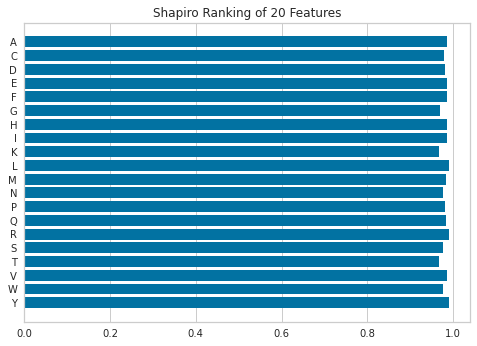

In [5]:
from yellowbrick.features import rank1d
rank1d(df_aac.to_numpy(), np.where(labels == "Sugar transport", 1, 0), features = df_aac.columns)
plt.show()

### Independent test set

In [6]:
X, y, feature_names, sample_names = preprocess_pandas(
    df_aac, labels, return_names=True
)
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2)



### Model selection

SVC (with default RBF kernel) looks the most promising.

In [7]:
models_quick_compare(X_train, y_train)

,0,1,2,3,4,mean,std
est,,,,,,,
GaussianNB(),0.593,0.683,0.808,0.679,0.839,0.720,0.102
KNeighborsClassifier(),0.842,0.927,0.936,0.839,0.557,0.820,0.154
LinearSVC(),0.680,0.737,0.942,0.699,0.778,0.767,0.104
LinearSVC(class_weight='balanced'),0.680,0.782,0.942,0.699,0.723,0.765,0.106
RandomForestClassifier(),0.604,0.842,0.562,0.839,0.778,0.725,0.133
RandomForestClassifier(class_weight='balanced'),0.604,0.842,0.683,0.734,0.778,0.728,0.091
SGDClassifier(),0.808,0.842,0.942,0.699,0.723,0.803,0.097
SVC(),0.842,0.729,0.683,0.926,0.734,0.783,0.099
SVC(class_weight='balanced'),0.878,0.708,0.936,0.862,0.862,0.849,0.085


### Parameter tuning

In [8]:
gsearch = optimize_hyperparams(X_train, y_train, kernel="rbf", dim_reduction=None, C=[1,10,100])
best_estimator_svc = gsearch

{'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.859


### Dimensionality reduction

In [9]:
gsearch = optimize_hyperparams(
    X_train, y_train, kernel="rbf", dim_reduction="kbest"
)
best_estimator_svc_kbest = gsearch


{'selectkbest__k': 18, 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.888


In [10]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    C=[1, 10, 100],
    gamma=[0.1, 0.01, 0.001],
)
best_estimator_svc_pca = gsearch


{'pca__n_components': 0.98, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01}
0.832


### Validation

In [11]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_kbest, labels=labels)

,Amino-acid transport,Sugar transport
Amino-acid transport,6,1
Sugar transport,2,15


In [12]:
get_classification_report(X_test, y_test, best_estimator_svc_kbest, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.750,0.857,0.800,7
Sugar transport,0.938,0.882,0.909,17
macro avg,0.844,0.870,0.855,24
weighted avg,0.883,0.875,0.877,24


In [13]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_pca, labels=labels)

,Amino-acid transport,Sugar transport
Amino-acid transport,5,2
Sugar transport,0,17


In [14]:
get_classification_report(X_test, y_test, best_estimator_svc_pca, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,1.000,0.714,0.833,7
Sugar transport,0.895,1.000,0.944,17
macro avg,0.947,0.857,0.889,24
weighted avg,0.925,0.917,0.912,24
